In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def are_there_expected_number_of_cycles(location_df, num_of_detections, cycle_length):
    first_date = pd.to_datetime(location_df['call_start_time']).iloc[0].date()
    last_date = (pd.to_datetime(location_df['call_start_time'])).iloc[-1].date()
    first_dt = dt.datetime.combine(first_date, pd.to_datetime(data_params['recording_start'], format="%H:%M").time())
    last_dt = dt.datetime.combine(last_date, pd.to_datetime(data_params['recording_end'], format="%H:%M").time())

    all_cycles = pd.date_range(first_dt, last_dt, freq=f'{cycle_length}T')
    between_time_cycles = all_cycles[(all_cycles.indexer_between_time(data_params['recording_start'], data_params['recording_end']))]
    
    assert num_of_detections.shape[0] <= between_time_cycles.shape[0]

In [6]:
def all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs):
    resampled_cycle_length_df = dc_applied_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    last_call_of_each_group = resampled_cycle_length_df.last()
    assert last_call_of_each_group['end_time_wrt_ref'].all() < time_on_in_secs

In [7]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs, data_params):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length, data_params)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)
    all_last_calls_of_cycle_within_recording(dc_applied_df, cycle_length, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length, data_params):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    first_call_of_each_group = resampled_cycle_length_df.first().between_time(data_params['recording_start'], data_params['recording_end'])
    are_there_expected_number_of_cycles(location_df, first_call_of_each_group, cycle_length)
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [8]:
def get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins):
    """
    Constructs a pandas Series that records the duration of time occupied by bouts observed per interval.
    The used interval is the cycle_length in minutes
    """

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{cycle_length_in_mins}T")['total_bout_duration_in_secs'].sum()

    return bout_duration_per_interval

def get_metric_per_time_on(metric, time_on):

    return metric / (time_on)

def filter_and_prepare_metric(metric, dc_tag, data_params):

    col_name = f"{data_params['metric_tag']} ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(metric.values, index=metric.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["datetime_UTC", col_name])

In [9]:
def does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df):
    assert dc_applied_df.shape[0] < location_df.shape[0]

In [10]:
def does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme):
    assert (metric_for_scheme_for_comparison.loc[metric_for_scheme.index].compare(metric_for_scheme).empty)

def do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison):
    assert metric_for_scheme_for_comparison.values.all() >= 0

In [11]:
def get_associated_metric_for_cont_column(metric_for_scheme, call_rate_cont_column):
    metric_for_scheme_for_comparison = metric_for_scheme.reindex(call_rate_cont_column.index, fill_value=0)
    does_reindexed_match_original_at_original_indices(metric_for_scheme_for_comparison, metric_for_scheme)
    do_calls_exist_in_reindexed_version(metric_for_scheme_for_comparison)

    return metric_for_scheme

def select_dates_from_metrics(metric_for_scheme_for_comparison, call_rate_cont_column, data_params):
    plt_dcmetr = metric_for_scheme_for_comparison.loc[data_params['start']:data_params['end']].copy()
    plt_cmetr = call_rate_cont_column.loc[data_params['start']:data_params['end']].copy()

    return plt_dcmetr, plt_cmetr

In [12]:
def add_placeholder_call_at_end_of_cycle(df, cycle_length):
    end_time_of_last_call = df.loc[len(df)-1, 'call_end_time']
    cycle_time_of_last_call = df.loc[len(df)-1, 'cycle_ref_time']
    next_cycle_time = cycle_time_of_last_call + pd.Timedelta(minutes=cycle_length)
    fake_call_start_time = next_cycle_time
    fake_call_end_time = next_cycle_time
    duration_from_last_ms = (next_cycle_time - end_time_of_last_call).total_seconds()*1000
    start_time_wrt_ref = (next_cycle_time - cycle_time_of_last_call).total_seconds()
    end_time_wrt_ref = start_time_wrt_ref

    mod_df = pd.concat([df, pd.DataFrame(df.loc[len(df)-1]).T], axis=0, ignore_index=True)

    mod_df.loc[len(mod_df)-1, 'call_status'] = 'bout end'
    mod_df.loc[len(mod_df)-1, 'change_markers'] = -1
    mod_df.loc[len(mod_df)-1, 'bout_tag'] = 0
    mod_df.loc[len(mod_df)-1, 'duration_from_last_call_ms'] = duration_from_last_ms
    mod_df.loc[len(mod_df)-1, 'start_time_wrt_ref'] = start_time_wrt_ref
    mod_df.loc[len(mod_df)-1, 'end_time_wrt_ref'] = end_time_wrt_ref
    mod_df.loc[len(mod_df)-1, 'ref_time'] = fake_call_start_time
    mod_df.loc[len(mod_df)-1, 'call_start_time'] = fake_call_start_time
    mod_df.loc[len(mod_df)-1, 'call_end_time'] = fake_call_end_time
    mod_df.loc[len(mod_df)-1, 'cycle_ref_time'] = cycle_time_of_last_call
    mod_df.loc[len(mod_df)-1, 'class'] = 'MADE-UP FOR DC INVESTIGATION'

    return mod_df

def add_placeholder_call_at_start_of_cycle(df):
    cycle_time_of_first_call = df.loc[0, 'cycle_ref_time']
    fake_call_start_time = cycle_time_of_first_call
    fake_call_end_time = cycle_time_of_first_call
    duration_from_last_ms = 0
    start_time_wrt_ref = 0
    end_time_wrt_ref = start_time_wrt_ref

    mod_df = pd.concat([pd.DataFrame(df.loc[0]).T, df], axis=0, ignore_index=True)

    mod_df.loc[0, 'call_status'] = 'bout start'
    mod_df.loc[0, 'change_markers'] = 1
    mod_df.loc[0, 'bout_tag'] = 0
    mod_df.loc[0, 'duration_from_last_call_ms'] = duration_from_last_ms
    mod_df.loc[0, 'start_time_wrt_ref'] = start_time_wrt_ref
    mod_df.loc[0, 'end_time_wrt_ref'] = end_time_wrt_ref
    mod_df.loc[0, 'ref_time'] = fake_call_start_time
    mod_df.loc[0, 'call_start_time'] = fake_call_start_time
    mod_df.loc[0, 'call_end_time'] = fake_call_end_time
    mod_df.loc[0, 'cycle_ref_time'] = cycle_time_of_first_call
    mod_df.loc[0, 'class'] = 'MADE-UP FOR DC INVESTIGATION'

    return mod_df

def add_placeholder_to_tag_dets_wrt_cycle(cycle_group, cycle_length):
    df = cycle_group.copy()
    df.reset_index(inplace=True, drop=True)

    first_call_within_another_bout = (df.loc[0, 'call_status']=='within bout')|(df.loc[0, 'call_status']=='bout end')
    if first_call_within_another_bout:
        mod_df = add_placeholder_call_at_start_of_cycle(df)
    else:
        mod_df = df.copy()

    last_call_within_another_bout = (mod_df.loc[len(mod_df)-1, 'call_status']=='within bout')|(mod_df.loc[len(mod_df)-1, 'call_status']=='bout start')
    if last_call_within_another_bout:
        mod_df = add_placeholder_call_at_end_of_cycle(mod_df, cycle_length)

    return mod_df

In [13]:
def construct_bout_metrics_from_classified_dets(fgroups_with_bouttags):
    """
    Reads in the dataframe of detected calls with bout tags.
    Uses these bout tags to create a new dataframe of bout metrics for the start and end times of each bout.
    Also includes the lowest frequency of a call within a bout as the lower bound for the bout
    and the highest frequency of a call within a bout as the upper bound frequency for the bout.
    Now, also included the number of detections captured within each bout.
    """

    location_df = fgroups_with_bouttags.copy()
    location_df.reset_index(drop=True, inplace=True)
    group_of_tagged_dets = location_df['freq_group'].unique().item()

    end_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout end', 'call_end_time'])
    start_times_of_bouts = pd.to_datetime(location_df.loc[location_df['call_status']=='bout start', 'call_start_time'])
    ref_end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time_wrt_ref'].astype('float')
    ref_start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time_wrt_ref'].astype('float')
    end_times = location_df.loc[location_df['call_status']=='bout end', 'end_time'].astype('float')
    start_times = location_df.loc[location_df['call_status']=='bout start', 'start_time'].astype('float')
    bout_starts = start_times_of_bouts.index
    bout_ends = end_times_of_bouts.index

    low_freqs = []
    high_freqs = []
    ref_time_cycle_start = []
    ref_time_cycle_end = []
    num_calls_per_bout = []
    for i, bout_start in enumerate(bout_starts):
        bat_bout = location_df.iloc[bout_start:bout_ends[i]+1]
        pass_low_freq = np.min(bat_bout['low_freq'])
        pass_high_freq = np.max(bat_bout['high_freq'])
        start_cycle = bat_bout['cycle_ref_time'].values[0]
        end_cycle = bat_bout['cycle_ref_time'].values[-1]
        num_calls = len(bat_bout)
        low_freqs += [pass_low_freq]
        high_freqs += [pass_high_freq]
        ref_time_cycle_start += [start_cycle]
        ref_time_cycle_end += [end_cycle]
        num_calls_per_bout += [num_calls]

    bout_metrics = pd.DataFrame()
    bout_metrics['start_time_of_bout'] = start_times_of_bouts.values
    bout_metrics['end_time_of_bout'] = end_times_of_bouts.values
    bout_metrics['start_time_wrt_ref'] = ref_start_times.values
    bout_metrics['end_time_wrt_ref'] = ref_end_times.values
    bout_metrics['start_time'] = start_times.values
    bout_metrics['end_time'] = end_times.values
    bout_metrics['low_freq'] = low_freqs
    bout_metrics['high_freq'] = high_freqs
    bout_metrics['freq_group'] = group_of_tagged_dets
    bout_metrics['cycle_ref_time_start'] = ref_time_cycle_start
    bout_metrics['cycle_ref_time_end'] = ref_time_cycle_end
    bout_metrics['number_of_dets'] = num_calls_per_bout
    bout_metrics['bout_duration'] = end_times_of_bouts.values - start_times_of_bouts.values
    bout_metrics['bout_duration_in_secs'] = bout_metrics['bout_duration'].apply(lambda x : x.total_seconds())

    return bout_metrics

In [14]:
def generate_bout_metrics_for_location_and_freq(location_sum_df, data_params, dc_tag):
    """
    Given a location summary of calls dataframe, create an analogous location summary of bouts by:
    1) Calculating the BCI for each frequency group in the summary.
    2) Use the calculated BCI for each group to cluster bouts for that group.
    3) Put together all bout characteristics into the analogous dataframe.
    """
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])

    location_sum_df.reset_index(drop=True, inplace=True)

    bout_params = bt.get_bout_params_from_location(location_sum_df, data_params)

    tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
    fixed_dets = tagged_dets.groupby('cycle_ref_time').apply(lambda x: add_placeholder_to_tag_dets_wrt_cycle(x, cycle_length_in_mins))
    fixed_dets.reset_index(drop=True, inplace=True)
    bout_metrics = construct_bout_metrics_from_classified_dets(fixed_dets)
    bt.test_bout_end_times_in_period(bout_metrics, time_on_in_mins)

    return bout_metrics

In [15]:
def generate_activity_btp_for_dc_schemes(data_params, file_paths):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

    dc_schemes = data_params['dc_tags'][1:]
    cont_scheme = data_params['dc_tags'][0]
    for dc_tag in dc_schemes:
        cycle_length_in_mins = int(dc_tag.split('of')[1])
        time_on_in_mins = int(dc_tag.split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)

        dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, 
                                                            time_on_in_secs, data_params)
        does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)

        bout_metrics = generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, dc_tag)
        bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins)
        bout_time_percentage = 100*get_metric_per_time_on(bout_duration, time_on_in_secs)
        bout_time_percentage_dc_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
        bout_time_percentage_dc_column = bout_time_percentage_dc_column.set_index("datetime_UTC")
        are_there_expected_number_of_cycles(dc_applied_df, bout_time_percentage_dc_column, cycle_length_in_mins)

        activity_arr = pd.concat([activity_arr, bout_time_percentage_dc_column], axis=1)

    return activity_arr

def get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params):
    dc_tag_split = re.findall(r"\d+", metric_col_name)
    dc_tag = re.findall(r"\d+of\d+", metric_col_name)[0]
    cycle_length = int(dc_tag_split[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cycle_length_in_secs = 60*cycle_length

    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
    dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length, 
                                                        cycle_length_in_secs, data_params)
    does_duty_cycled_df_have_less_dets_than_original(dc_applied_df, location_df)
    bout_metrics = generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, cont_tag)

    bout_duration = get_bout_duration_per_cycle(bout_metrics, cycle_length)
    bout_time_percentage = 100*get_metric_per_time_on(bout_duration, cycle_length_in_secs)
    bout_time_percentage_cont_column = filter_and_prepare_metric(bout_time_percentage, dc_tag, data_params)
    bout_time_percentage_cont_column = bout_time_percentage_cont_column.set_index("datetime_UTC")
    are_there_expected_number_of_cycles(location_df, bout_time_percentage_cont_column, cycle_length)

    return bout_time_percentage_cont_column

In [26]:
def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.rcParams.update({'font.size':12})
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time_percentage'):
        plt.xlim(1e-2, 1e2)
        plt.ylim(1e-2, 1e2)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [17]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LFCarp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LFCarp',
 

In [18]:
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

In [19]:
activity_arr = generate_activity_btp_for_dc_schemes(data_params, file_paths)

In [20]:
metric_for_scheme = pd.DataFrame(activity_arr.iloc[:,3].dropna())
metric_col_name = metric_for_scheme.columns[0]
btp_cont_column = get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)

In [21]:
metric_for_scheme_for_comparison = get_associated_metric_for_cont_column(metric_for_scheme, btp_cont_column)

data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

plt_dcmetr, plt_cmetr = select_dates_from_metrics(metric_for_scheme_for_comparison, btp_cont_column, data_params)

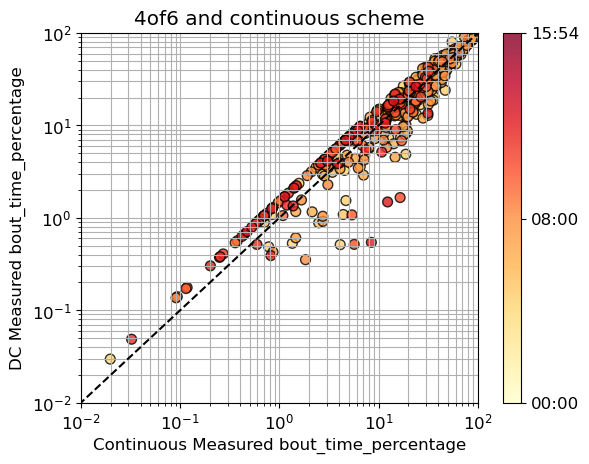

In [27]:
plot_indiv_dc_control_comp_over_cycle(plt_dcmetr, plt_cmetr, data_params)